In [255]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# Path template for loading data

PROJECT_PATH = "/home/dmitrii/GitHub/ukbb_risk_assessment/"
path_template = PROJECT_PATH + "/analysisNumericFeatures/tabular_experiment/results/results_cv_fi_best_2/{dataset_name}/non_image+total_segmentator/feature_importances/*/{split}/feature_importances_seed_*.csv"

dataset_names = [
    "cvd2_3m_3y",
                 "pancreas_3m_3y", 
                 "liver_3m_3y", 
                 "cancer_3m_3y", 
                 "copd_3m_3y", 
                 "ckd_3m_3y", 
                 "osteoarthritis_3m_3y"
                 ]  # Replace with actual dataset names

significance_threshold = 0.05 / (14 * 1) # Bonferroni-corrected significance threshold

# Initialize dictionary to store average importances by dataset and category
avg_importances = {}

for dataset_name in dataset_names:
    for split in range(5):
        csv_files = glob.glob(path_template.format(dataset_name=dataset_name, split=split))
        category_importances = []
        
        for file in csv_files:
            df = pd.read_csv(file)
            # Filter rows by p-value threshold
            significant_df = df[df['p_value'] < significance_threshold]
            category_importances.append(significant_df[['category', 'importance']])
        
        # Concatenate data from all significant seeds
        combined_df = pd.concat(category_importances)
        # Calculate mean importance for each category, ignoring non-significant values
        mean_importance = combined_df.groupby('category')['importance'].mean()
        avg_importances[dataset_name] = mean_importance




In [247]:
avg_importances

{'cvd2_3m_3y': category
 bone           0.017563
 digestive      0.012816
 endocrine      0.014873
 fat            0.020253
 heart          0.011076
 kidney         0.015506
 liver          0.011076
 muscle         0.021203
 pancreas       0.017405
 respiratory    0.020781
 spine          0.014399
 spleen         0.012342
 vascular       0.015401
 Name: importance, dtype: float64,
 'pancreas_3m_3y': category
 bone           0.032627
 digestive      0.016525
 endocrine      0.010734
 fat            0.044068
 kidney         0.013559
 liver          0.007627
 muscle         0.024294
 pancreas       0.016949
 respiratory    0.026271
 spine          0.031638
 spleen         0.010169
 vascular       0.027119
 Name: importance, dtype: float64,
 'liver_3m_3y': category
 bone           0.025762
 digestive      0.047927
 endocrine      0.025183
 fat            0.022988
 heart          0.024573
 kidney         0.026418
 liver          0.018476
 muscle         0.052043
 pancreas       0.029634
 re

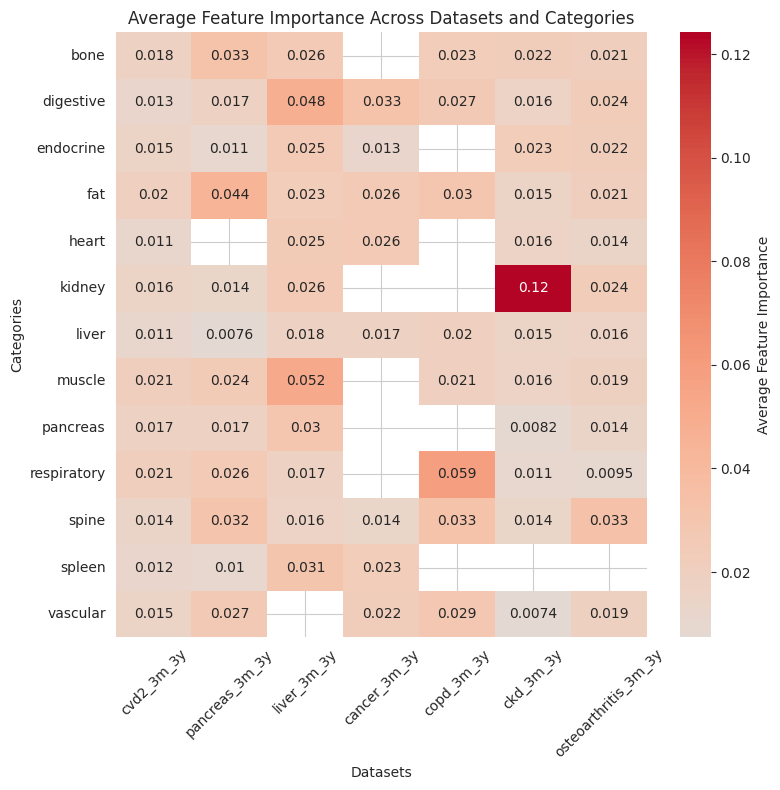

In [248]:
heatmap_data = pd.DataFrame(avg_importances)
#sns.set(style="darkgrid")

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, center=0, annot=True, cmap="coolwarm", cbar_kws={'label': 'Average Feature Importance'})
plt.title("Average Feature Importance Across Datasets and Categories")
plt.xlabel("Datasets")
plt.ylabel("Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

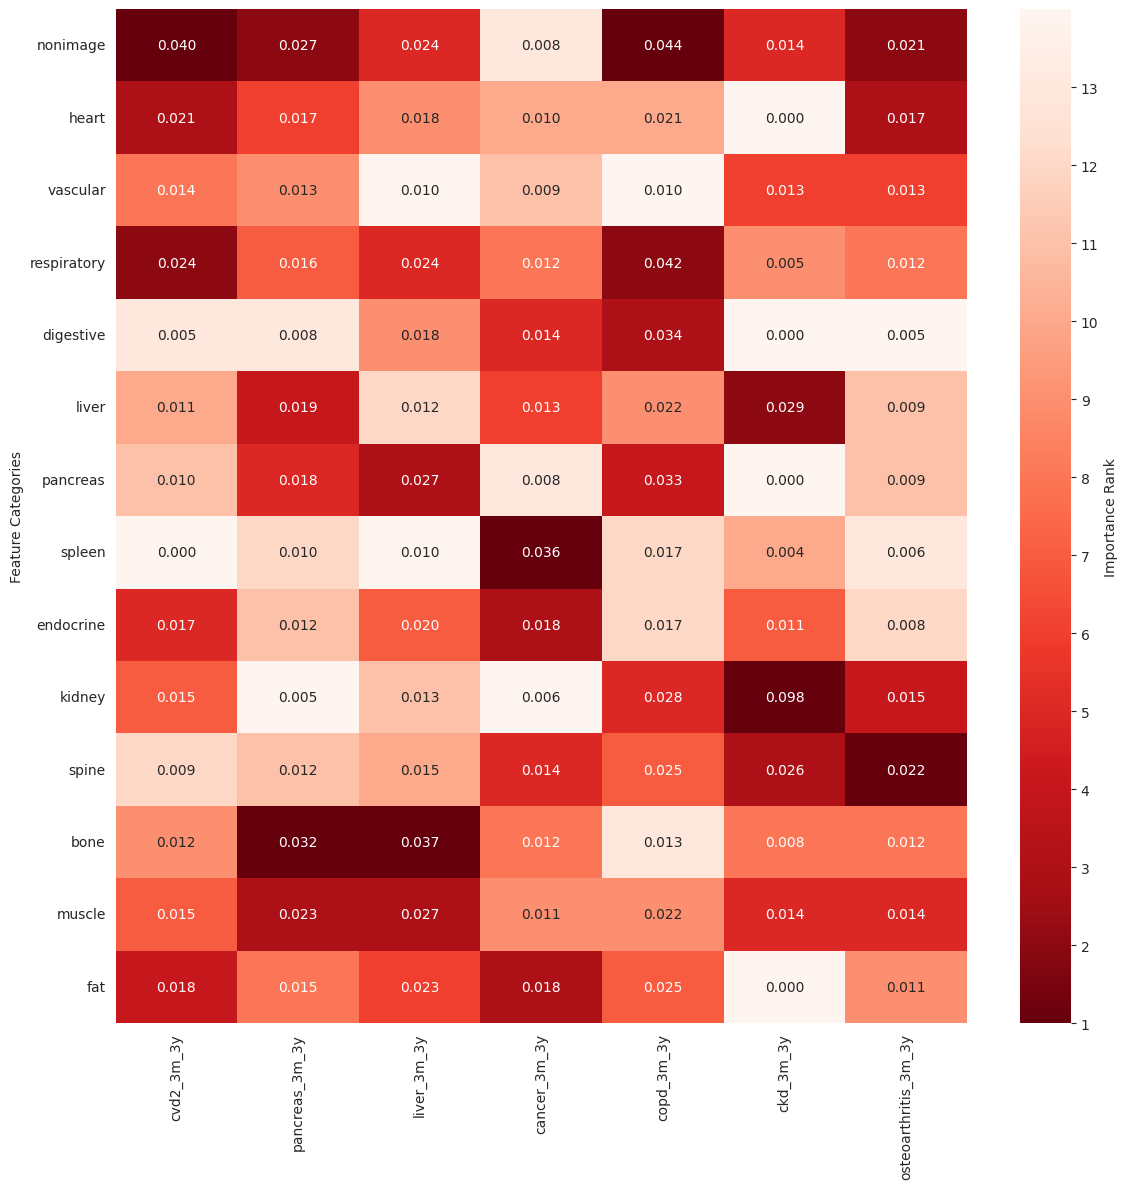

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
DIGITS_AFTER_DECIMAL = 3

# Assuming dataset_correlations is a pre-existing 2D array of MAC values
# Convert dataset_correlations into a DataFrame for visualization
desired_order = [
    "nonimage",
    "heart", "vascular", "respiratory", "digestive", "liver", "pancreas", 
    "spleen", "endocrine", "kidney", "spine", "bone", "muscle", "fat"
]

#desired_order = [
#        "heart", "vascular_artery", "vascular_vein", "respiratory", "digestive", "liver", "pancreas", 
#    "spleen", "endocrine", "kidney", "spine", "bone", "muscle", "subcutaneous_fat", "inner_fat"
#]

df_corr = pd.DataFrame(avg_importances)
df_corr = df_corr.reindex(desired_order)

df_corr = df_corr.fillna(0)

# Round the original MAC values to 2 decimal places
df_corr = df_corr.round(DIGITS_AFTER_DECIMAL)

# Custom ranking function to create ranks with gaps based on frequency of identical values
# Custom ranking function to assign ranks with gaps
def custom_rank_with_gaps(column):
    # Step 1: Calculate the dense ranks (descending order)
    initial_ranks = column.abs().rank(method='dense', ascending=False)
        # Create a dictionary to store frequency of each rank
    rank_counts = initial_ranks.value_counts().sort_index()
    
    # Create mapping for new ranks
    new_rank = 0
    rank_mapping = {}
    
    for rank, count in rank_counts.items():
        # For each rank, the new rank will be current position + count - 1
        new_rank = new_rank + count
        rank_mapping[rank] = new_rank
    
    # Map the new ranks
    transformed_ranks = initial_ranks.map(rank_mapping)
    
    return transformed_ranks

ranked_corr = df_corr.apply(custom_rank_with_gaps, axis=0)
# Plot the heatmap using the 'Reds' colormap, with ranked values for color and rounded values as annotations
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(ranked_corr, annot=df_corr, fmt=f".{DIGITS_AFTER_DECIMAL}f", cmap="Reds_r", cbar_kws={'label': 'Importance Rank'}, 
                      vmin=1, vmax=14)  # Using rank-based coloring

# Customize color bar to show ticks from 1 to 13
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks(range(1, 14))  # Set ticks at each integer from 1 to 13
colorbar.set_ticklabels(range(1, 14))  # Set tick labels to match each rank

#plt.title("Average Feature Importances of Radiomic Feature Categories by Dataset (Column-wise Ranked)")
#plt.xlabel("Datasets")
plt.ylabel("Feature Categories")
plt.tight_layout()
plt.savefig("/home/dmitrii/Desktop/figures/feature_importance_ranked.png", dpi=600)
plt.show()




In [252]:
ranked_corr

,cvd2_3m_3y,pancreas_3m_3y,liver_3m_3y,cancer_3m_3y,copd_3m_3y,ckd_3m_3y,osteoarthritis_3m_3y
category,,,,,,,
heart,13,13,8,3,13,6,11
vascular,8,4,13,5,4,12,8
respiratory,2,5,11,13,1,10,12
digestive,10,8,2,1,5,6,3
liver,13,12,10,6,8,8,9
pancreas,5,8,4,13,13,11,11
spleen,11,11,3,4,13,13,13
endocrine,8,10,8,8,13,2,4
kidney,6,9,6,13,13,1,3


In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re

# Set significance threshold
significance_threshold =1

# Initialize dictionary to store average importances by dataset and organ
avg_importances = {}

# Function to strip `_fat` and `_wat` suffixes
def strip_suffix(category):
    return re.sub(r'_(fat|wat)$', '', category)

# Assuming dataset_names and path_template are defined as before
for dataset_name in dataset_names:
    csv_files = glob.glob(path_template.format(dataset_name=dataset_name))
    category_importances = []
    
    for file in csv_files:
        df = pd.read_csv(file)
        # Filter rows by p-value threshold
        significant_df = df[df['p_value'] < significance_threshold]
        # Strip suffixes and calculate mean importance
        significant_df['organ'] = significant_df['category'].apply(strip_suffix)
        mean_df = significant_df.groupby('organ')['importance'].mean().reset_index()
        mean_df.columns = ['category', 'importance']
        category_importances.append(mean_df)
    
    # Concatenate all seed data and calculate the final mean importance by organ
    combined_df = pd.concat(category_importances)
    mean_importance = combined_df.groupby('category')['importance'].mean()
    avg_importances[dataset_name] = mean_importance

# Convert results to DataFrame for visualization
heatmap_data = pd.DataFrame(avg_importances)

# Plot heatmap centered around zero
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="coolwarm",  # A diverging color palette for centered values
    center=0,  # Center the colormap at zero
    cbar_kws={'label': 'Average Feature Importance (Thresholded)'}
)
plt.title("Average Feature Importance Across Datasets and Categories (Significant Only)", pad=20, loc='center', verticalalignment='bottom')
plt.xlabel("Datasets", labelpad=10)
plt.ylabel("Categories", labelpad=10)
plt.xticks(rotation=45)
plt.gca().xaxis.tick_top()  # Place x-axis labels at the top
plt.gca().xaxis.set_label_position('top')  # Place x-axis label at the top
plt.tight_layout()
plt.show()


KeyError: 'split'